In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

# Print out GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

# Virtual Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


Thu Jun  9 14:43:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 25%   38C    P2    27W / 120W |    619MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

ModuleNotFoundError: No module named 'psutil'

In [ ]:
cd /content/drive/MyDrive/Thesis

In [ ]:
!git clone https://github.com/kchare/advex_notbugs_features.git

In [ ]:
# !pip install tensorflow-addons
!pip install -U segmentation-models

In [ ]:
!python --version

In [9]:

# for data load
import os

# for reading and processing images
import imageio
from PIL import Image, ImageOps

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split


from tensorflow import keras as K
# import tensorflow_datasets as tfds

print(f"Tensorflow ver. {tf.__version__}")


from tensorflow.keras.utils import get_source_inputs
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import pandas as pd
import time
# SM_FRAMEWORK=K
SM_FRAMEWORK=tf.keras
import segmentation_models as sm
sm.set_framework('tf.keras')
K.backend.set_image_data_format('channels_last')
seed=25
np.random.seed(25)
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow ver. 2.9.1


In [10]:
model = sm.Unet('resnet50', classes=11, activation='softmax', encoder_weights='imagenet')

2022-06-09 14:43:22.076667: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25MiB (rounded to 2359296)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-06-09 14:43:22.076707: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-06-09 14:43:22.076719: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 95, Chunks in use: 95. 23.8KiB allocated for chunks. 23.8KiB in use in bin. 16.2KiB client-requested in use in bin.
2022-06-09 14:43:22.076728: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 64, Chunks in use: 64. 32.2KiB allocated for chunks. 32.2KiB in use in bin. 32.0KiB client-requested in use in bin.
2022-06-09 14:43:22.076736: I tensor

ResourceExhaustedError: failed to allocate memory [Op:Mul]

In [ ]:
model.summary()

In [11]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    
    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()
    
    return orig_img, mask_img

In [12]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask
    
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.float32)
    
    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path)
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) 
        single_img = single_img/256.
        X[index] = single_img
        
        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path)
        single_mask = ImageOps.grayscale(single_mask)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c)) 
        single_mask = single_mask - 1 # to ensure classes #s start from 0
        y[index] = single_mask
    return X, y

In [14]:
path1 = './dataset/images/'
path2 = './dataset/masks/'
img, mask = LoadData (path1, path2)
print(len(img))
# View an example of image and corresponding mask 
# show_images = 2
# # for i in range(show_images):
# img_view  = imageio.imread(path1 + img[1])
# mask_view = imageio.imread(path2 + mask[1])
# print(img_view.shape)
# print(mask_view.shape)
# fig, arr = plt.subplots(1, 2, figsize=(15, 15))
# arr[0].imshow(img_view)
# arr[0].set_title('Image '+ str(1))
# arr[1].imshow(mask_view)
# arr[1].set_title('Masked Image '+ str(1))

1442


X Shape: (1442, 128, 128, 3)
Y shape: (1442, 128, 128, 1)
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9. 255.]


Text(0.5, 1.0, 'Processed Masked Image ')

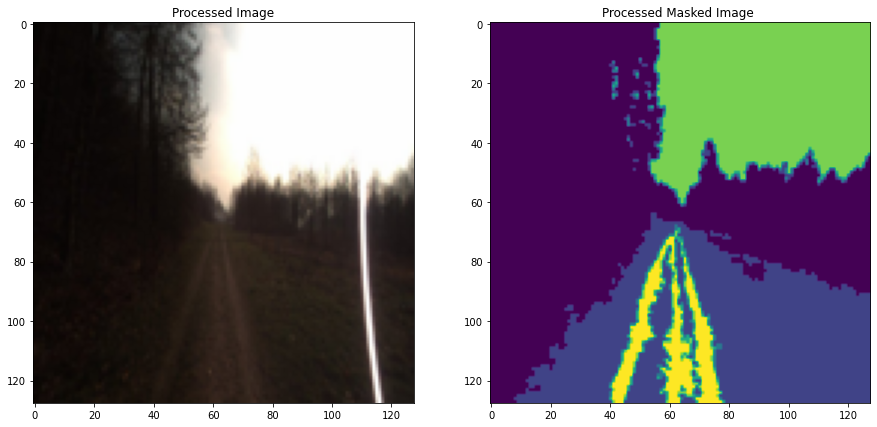

In [15]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 3 classes : background, pet, outline
print(np.unique(y))

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

In [ ]:

# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=seed)


# def train_preprocess(img, label):
#   img /= 255
#   img = tf.cast(img, tf.float32)
#   img = tf.image.resize_with_pad(img, 32+4, 32+4)
#   img = tf.image.random_crop(img, size=[32, 32, 3])
#   img = tf.image.stateless_random_flip_left_right(img, (15, 13))
#   return img, label

# def test_preprocess(img, label):
#   img = tf.cast(img, tf.float32)
#   img /= 255
#   return img, label

In [ ]:
model.compile(
    K.optimizers.Adam(0.0001),
    loss=sm.losses.CategoricalFocalLoss(),
    metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)],
)

In [ ]:
# results = unet.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_valid, y_valid))

results = model.fit(
   x=X_train,
   y=y_train,
   batch_size=16,
   epochs=100,
   validation_data=(X_valid, y_valid),
)

In [ ]:
# Save the model
model.save('drive/MyDrive/Seg/models/standard_training_UnetResnet.h5')

In [ ]:
def norm(Z):
    """Compute norms over all but the first dimension"""
    return tf.norm(tf.reshape(Z, (Z.shape[0], -1)), axis=1)

# PGD L2 for Adversarial Examples #
def single_pgd_step_adv(model, X, y, alpha, epsilon, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE # Use no aggregation - will give gradient separtely for each ex.
            )(y, model(X + delta)) # comparing to label for original data point
    grad = tape.gradient(loss, delta)

    normgrad = tf.reshape(norm(grad), (-1, 1, 1, 1))
    z = delta + alpha * (grad / (normgrad + 1e-10))

    normz = tf.reshape(norm(z), (-1, 1, 1, 1))
    delta = epsilon * z / (tf.math.maximum(normz, epsilon) + 1e-10)
    return delta, loss

def pgd_l2_adv(model, X, y, alpha, num_iter, epsilon=0, example=False):
    fn = tf.function(single_pgd_step_adv)
    delta = tf.zeros_like(X)
    loss = 0
    for t in range(num_iter):
        delta, loss = fn(model, X, y, alpha, epsilon, delta)
        
    if example:
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta

In [ ]:
# Helper for pgd_linf
@tf.function
def onestep_pgd_linf(model, X, y, epsilon, alpha, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE
        )(y, model(X + delta))

    delta = tf.clip_by_value(delta + alpha*tf.sign(tape.gradient(loss, delta)), X-epsilon, X+epsilon)
    
    return delta

# Full run – import this 
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = tf.zeros_like(X)
    for t in range(num_iter):
        delta = onestep_pgd_linf(model, X, y, epsilon, alpha, delta)
    return delta

In [ ]:
@tf.function
def fgsm_attack(model, X, y, epsilon=0.1):
    delta = tf.zeros_like(X)
    
    # use GradientTape to perform autodiff
    with tf.GradientTape() as tape:
        # specifically 'watch' delta
        # see here: https://www.tensorflow.org/guide/autodiff
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE
        )(y, model(X + delta))
    delta = tf.sign(tape.gradient(loss, delta)) * epsilon
    return delta

In [ ]:
def run_adversarial_attack(model, X_valid, y_valid , attack, attack_params=None, **kwargs):
    """Runs only the adversarial attack on a trained model. 
    
    Differs from standard training by skipping the gradient updates which can be highly costly. Can be
    demonstrated from training model in standard way and then applying"""
    # Convert function to tf function
    attack_fn = tf.function(attack)

    t = time.time()
    test_losses = []
    test_accs = []
    for i in range(len(X_valid)):
        Xtest = X_valid[i]
        ytest = y_valid[i]

        # Run attack perturbation
        if attack_params is not None:
            delta = attack_fn(model, Xtest, ytest, **attack_params)
        else:
            delta = attack_fn(model, Xtest, ytest, **kwargs)

        Xdtest = Xtest + delta
        l, acc = model.test_on_batch(Xdtest, ytest)
        test_losses.append(l)
        test_accs.append(acc)
    
    test_loss = sum(test_losses) / len(test_losses)
    test_acc = sum(test_accs) / len(test_accs)
    print(f"Time: {(time.time()-t):0.2f} Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")

In [ ]:
def standard_training(model, train_ds, test_ds, attack=None, epochs=5, verbose=True, **kwargs):
    """Runs the "standard" training loop described in Ilyas et al. (2019)
    
    Standard training includes non-adversarial training during each training step. Includes
    optional adversarial attacks at test time described by the `attack` argument
    
    Args:
        - model (TFModel): A compiled TF / Keras model
        - train_ds (TFData): a tensorflow data object for the training data
        - test_ds (TFData): a tensorflow data object for the test data 
        - attack (function): an attack function (i.e. PGD L2) to perturb
                test data if evaluating adversarial performance. Default : None
        - epochs (int): number of epochs to run training. Default: 5.
        - verbose (bool): Report results after each epoch. Otherwise
                will return the train / test accuracies at the end of training. 
                Default: True"""

    for n in range(epochs):
    
        t = time.time()
        train_losses = []
        train_accs = []
        for b in train_ds:
            X, y = b

            l, acc = model.train_on_batch(X, y)
            train_losses.append(l)
            train_accs.append(acc)

        test_losses = []
        test_accs = []
        for vb in test_ds:
            Xtest, ytest = vb
            
            # When attack is specified (ie not None), apply
            # attack at test time; do not apply in training due to
            # 'standard_training' definition
            if attack is not None:
                delta = attack(model, Xtest, ytest, **kwargs)
                Xdtest = Xtest + delta
            else:
                Xdtest = Xtest
            
            l, acc = model.test_on_batch(Xdtest, ytest)
            test_losses.append(l)
            test_accs.append(acc)
        
        train_loss = sum(train_losses) / len(train_losses)
        train_acc = sum(train_accs) / len(train_accs)
        
        test_loss = sum(test_losses) / len(test_losses)
        test_acc = sum(test_accs) / len(test_accs)
        
        if verbose:
            print(f"Epoch {n}/{epochs}, Time: {(time.time()-t):0.2f} -- Train Loss: {train_loss:0.2f}, \
                Train Acc: {train_acc:0.2f}, Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")
    
    # Return final train and test losses
    if verbose == False:
        return {'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc}

In [ ]:
def adversarial_training(model, train_ds, test_ds, train_attack=pgd_l2_adv, test_attack=None, epochs=5, verbose=True, test_kwargs=None, **kwargs):
    """Runs the "adversarial" training loop described in Ilyas et al. (2019)
    
    Adversarial training allows for two separate attacks, one during training and a separate one during
    test. Note that if 'train_attack' is set to None, then this becomes standard training.
    
    Args:
        - model (TFModel): A compiled TF / Keras model
        - train_ds (TFData): a tensorflow data object for the training data
        - test_ds (TFData): a tensorflow data object for the test data 
        - attack (function): an attack function (i.e. PGD L2) to perturb
                test data if evaluating adversarial performance. Default : None
        - epochs (int): number of epochs to run training. Default: 5.
        - verbose (bool): Report results after each epoch. Otherwise
                will return the train / test accuracies at the end of training. 
                Default: True"""

    # Create train and test functions wrapped
    if train_attack is not None:
      train_attack_tf = tf.function(train_attack)
    if test_attack is not None:
      test_attack_tf = tf.function(test_attack)

    for n in range(epochs):
    
        t = time.time()
        train_losses = []
        train_accs = []
        for b in train_ds:
            X, y = b

            # Create adversarially perturbed training data
            if train_attack is not None:
                delta = train_attack_tf(model, X, y, **kwargs)
                Xd = X + delta
            else:
                Xd = X  
            # Train model on adversarially perturbed data
            l, acc = model.train_on_batch(Xd, y)
            train_losses.append(l)
            train_accs.append(acc)

        test_losses = []
        test_accs = []
        for vb in test_ds:
            Xtest, ytest = vb
            
            # When attack is specified (ie not None), apply
            # attack at test time; do not apply in training due to
            # 'standard_training' definition
            if test_attack is not None:
                if isinstance(test_kwargs, dict):
                    delta = test_attack_tf(model, Xtest, ytest, **test_kwargs)
                else:
                    delta = test_attack_tf(model, Xtest, ytest)
                Xdtest = Xtest + delta
            else:
                # when test_attack is not specified 
                Xdtest = Xtest
            
            l, acc = model.test_on_batch(Xdtest, ytest)
            test_losses.append(l)
            test_accs.append(acc)
        
        train_loss = sum(train_losses) / len(train_losses)
        train_acc = sum(train_accs) / len(train_accs)
        
        test_loss = sum(test_losses) / len(test_losses)
        test_acc = sum(test_accs) / len(test_accs)
        
        if verbose:
            print(f"Epoch {n}/{epochs}, Time: {(time.time()-t):0.2f} -- Train Loss: {train_loss:0.2f}, \
                Train Acc: {train_acc:0.2f}, Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")
    
    # Return final train and test losses
    if verbose == False:
        return {'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc}

In [ ]:
def single_pgd_step_robust(model, X, y, alpha, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE
        )(y, model(X + delta)) # comparing to robust model representation layer
        
    grad = tape.gradient(loss, delta)
    normgrad = tf.reshape(norm(grad), (-1, 1, 1, 1))
    delta -= alpha*grad / (normgrad + 1e-10) # normalized gradient step
    delta = tf.math.minimum(tf.math.maximum(delta, -X), 1-X) # clip X+delta to [0,1]
    return delta, loss

def pgd_l2_robust(model, X, y, alpha, num_iter, epsilon=0, example=False):
    delta = tf.zeros_like(X)
    loss = 0
    fn = tf.function(single_pgd_step_robust)
    for t in range(num_iter):
      delta, loss = fn(model, X, y, alpha, delta)
    # Prints out loss to evaluate if it's actually learning (currently broken)
    if example:
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta

In [ ]:
def single_pgd_step_nonrobust(model, X, y, alpha, epsilon, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE # Use no aggregation - will give gradient separtely for each ex.
            )(y, model(X + delta)) # comparing to label for original data point
    grad = tape.gradient(loss, delta) #tape.gradient(loss, delta)

    # equivalent to delta += alpha*grad / norm(grad), just for batching
    normgrad = tf.reshape(norm(grad), (-1, 1, 1, 1))
    # changed from plus to minus b/c trying to minimize with non-robust
    z = delta - alpha * (grad / (normgrad + 1e-10))
    normz = tf.reshape(norm(z), (-1, 1, 1, 1))
    delta = epsilon * z / (tf.math.maximum(normz, epsilon) + 1e-10)
    return delta, loss

def pgd_l2_nonrobust(model, X, y, alpha, num_iter, epsilon=0, example=False):
    fn = tf.function(single_pgd_step_nonrobust)
    delta = tf.zeros_like(X)
    loss = 0
    for t in range(num_iter):
        delta, loss = fn(model, X, y, alpha, epsilon, delta)
        
    if example:
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta

In [ ]:
for i, ex in enumerate(train_ds):
  X, y = ex
  epsilon = 0.5
  delta = pgd_l2_adv(mod, X, y, epsilon=epsilon, alpha=epsilon / 5, num_iter=7)
  Xd = X + delta
  delta_grad = delta
  if i > 2:
    break


In [ ]:
# Show the original image, the adversarial image, and the difference
n = 3
t = (X[n]).numpy()
td = (Xd[n]).numpy()
delta_d = (delta[n]).numpy()+0.5 # Added 0.5 to show differences

fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs = axs.flatten()
axs[0].imshow(t)
axs[1].imshow(td)
axs[2].imshow(delta_d)
plt.show()

In [ ]:
# Compile ResNet via Adam
boundaries = [15000, 20000]
values = [0.1, 0.01, 1e-3]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

tf.keras.backend.clear_session()
std_training = ResNet56(3, 16, l2=2e-4)
std_training.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    #optimizer = tf.keras.optimizers.Adam(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, 
                                       momentum=0.9),
    metrics=['accuracy']
)

In [ ]:
standard_training(std_training, train_ds, test_ds, attack=None , epochs=25000 // 391)

In [ ]:
# Save the model
std_training.save('drive/MyDrive/AM207_Final_Project/models/standard_training_resnet9_16')

In [ ]:
std_training = tf.keras.models.load_model('drive/MyDrive/AM207_Final_Project/models/standard_training_resnet9_16')

In [ ]:
run_adversarial_attack(model, X_valid, y_valid, attack=pgd_l2_adv, attack_params={'epsilon':0.25, 'num_iter':7, 'alpha':0.5/5})

In [ ]:
# PGD L-infinity attack
run_adversarial_attack(std_training, test_ds, attack=pgd_linf, attack_params={'epsilon':0.25, 'num_iter':7, 'alpha':0.5/5}) # {'epsilon':0.5, 'num_iter':7,

In [ ]:
# FGSM attack
run_adversarial_attack(std_training, test_ds, attack=fgsm_attack, attack_params={'epsilon':0.25})

In [ ]:
tf.keras.backend.clear_session()
adv_training = ResNet56(3, 16, l2=2e-4)
adv_training.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, 
                                       momentum=0.9),
    metrics=['accuracy']
)



In [ ]:
adv_training1.summary()

In [ ]:
adversarial_training(adv_training, train_ds, test_ds, train_attack=pgd_l2_adv, epsilon=0.5, num_iter=7, alpha=0.5 / 5, epochs=25000 // 391)

In [ ]:
adv_training.save('drive/MyDrive/AM207_Final_Project/models/adv_training1_resnet9_16')

In [ ]:
# Load the model
adv_training = tf.keras.models.load_model('drive/MyDrive/AM207_Final_Project/models/adv_training1_resnet9_16')

In [ ]:
adv_training.summary()

In [ ]:
# PGD L2 attack
run_adversarial_attack(adv_training, test_ds, attack=pgd_l2_adv, attack_params={'epsilon':0.25, 'num_iter':7, 'alpha':0.5/5})

In [ ]:
# PGD L-infinity attack
run_adversarial_attack(adv_training, test_ds, attack=pgd_linf, attack_params={'epsilon':0.25, 'num_iter':7, 'alpha':0.5/5})

In [ ]:
# FGSM attack
run_adversarial_attack(adv_training, test_ds, attack=fgsm_attack, attack_params={'epsilon':0.25})

(3) Robust Features
Create Robustifier

In [ ]:
representation = adv_training.layers[-2]
representation.output

In [ ]:
# Create the robustifier model 
# (which is the adversarially trained model without the last layer)
adv_training.summary()
representation = adv_training.layers[-2]
robustifier = tf.keras.Model(inputs = adv_training.layers[0].input, outputs = representation.output)
robustifier.summary()

In [ ]:
robustifier.summary()

In [ ]:
# Save the robustifier model
robustifier.save('drive/MyDrive/AM207_Final_Project/models/robustifier1_resnet9_16')

In [ ]:
robustifier = tf.keras.models.load_model('drive/MyDrive/AM207_Final_Project/models/robustifier1_resnet9_16')

Create Robust Dataset

In [ ]:
%%time
def robustify(robust_mod, train_ds, iters=1000, alpha=0.1, batch_size=BATCH_SIZE):
  robust_train = []
  orig_labels = []
  example = False

  train_to_pull = list(iter(train_ds))
  start_rn = np.random.randint(0, len(train_ds))
  rand_batch = train_to_pull[start_rn][0]

  start_time = time.time()
  for i, (img_batch, label_batch) in enumerate(train_ds):
      inter_time = time.time()  

      # For the last batch, it is smaller than batch_size and thus we match the size for the batch of initial images
      if img_batch.shape[0] < batch_size:
        rand_batch = rand_batch[:img_batch.shape[0]]

      # Get the goal representation
      goal_representation = robust_mod(img_batch)
      
      # Upate the batch of images
      learned_delta = pgd_l2_robust(robust_mod, rand_batch, goal_representation, alpha=alpha, num_iter=iters)
      robust_update = (rand_batch + learned_delta)

      # Add the updated images and labels to their respective lists
      robust_train.append(robust_update)
      orig_labels.append(label_batch)
      
      # Measure the time
      if (i+1) % 10 == 0:
        elapsed = time.time() - start_time
        elapsed_tracking = time.time() - inter_time
        print(f'Robustified {(i+1)*batch_size} images in {elapsed:0.3f} seconds; Took {elapsed_tracking:0.3f} seconds for this particular iteration')    
      
      # Reset random image batch
      rn = np.random.randint(0, len(train_ds)-1) # -1 because last batch might be smaller
      rand_batch = train_to_pull[rn][0]

  return robust_train, orig_labels

robust_train, orig_labels = robustify(robustifier, train_ds, iters=1000, alpha=0.1)

# Print out the shapes
print(tf.concat(robust_train, axis=0).shape)
print(tf.concat(orig_labels, axis=0).shape)

In [ ]:
def robust_preprocess(img, label):
  """Defines preprocessing / data augmentation for robust & nonrobust features"""
  img = tf.image.resize_with_pad(img, 32+4, 32+4)
  img = tf.image.random_crop(img, size=[32, 32, 3])
  img = tf.image.stateless_random_flip_left_right(img, (15, 13)) 
  return img, label

In [ ]:
# Convert to TensorFlow Dataset
robust_ds = tf.data.Dataset.from_tensor_slices((tf.concat(robust_train, axis=0), tf.concat(orig_labels, axis=0))).prefetch(AUTOTUNE).map(robust_preprocess, 
                                                                                                                                         num_parallel_calls=AUTOTUNE).shuffle(
                                                                                                                                             len(robust_train)).batch(BATCH_SIZE)

Save/Load Dataset

In [ ]:
# Save the tensorflow datasets
tf.data.experimental.save(robust_ds, 'drive/MyDrive/AM207_Final_Project/resnet9_robust_ds')
# Load the tensorflow datasets
robust_ds_new = tf.data.experimental.load('drive/MyDrive/AM207_Final_Project/resnet9_robust_ds')

In [ ]:
len(robust_ds)

Standard testing RObust

In [ ]:
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [15000, 20000], [0.1, 0.01, 1e-3])

robust_training = ResNet56(3, 16, l2=2e-4)
robust_training.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, 
                                      momentum=0.9),
    #optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

In [ ]:
# Train the model on the non-robust dataset
standard_training(robust_training, robust_ds, test_ds, attack=None, epochs=25000 // 391)

In [ ]:
# Save the model
robust_training.save('drive/MyDrive/AM207_Final_Project/models/robust_training_resnet9_16')

In [ ]:
# PGD L2 attack
run_adversarial_attack(robust_training, test_ds, attack=pgd_l2_adv, attack_params={'epsilon':0.25, 'num_iter':7, 'alpha':0.25/5})

In [ ]:
# PGD L-infinity attack
run_adversarial_attack(robust_training, test_ds, attack=pgd_linf, attack_params={'epsilon':0.25, 'num_iter':7, 'alpha':0.5/5}) # {'epsilon':0.5, 'num_iter':7, 'a

In [ ]:
# FGSM attack
run_adversarial_attack(robust_training, test_ds, attack=fgsm_attack, attack_params={'epsilon':0.25})

(4) Non-Robust Features

Create Non-Robust Dataset

In [ ]:
original_train = []
non_robust_train = []
t_train = [] 
y_train = []
iters = 100


start_time = time.time()
# Loops through entire train dataset image-by-image
for i, (img_batch, label_batch) in enumerate(train_ds): # Unbatch splits batches into individual images
    inter_time = time.time()  

    # Create a copy of the tensor
    img_batch_t = tf.identity(img_batch)

    # Generate a random label, get the delta and add in the perturbation (random uniform approach)
    t_batch = np.random.randint(low=0, high=9, size=img_batch_t.shape[0]) # t_batch = (label_batch + 1) % 10   <-- deterministic approach
    
    # Update the image so that it is non-robust
    learned_delta = pgd_l2_nonrobust(std_training, img_batch_t, t_batch, epsilon=0.5, alpha=0.1, num_iter=iters)
    non_robust_update = img_batch_t + learned_delta

    # Append both the original and non-robust images and labels to the respective lists
    original_train.append(img_batch)
    y_train.append(label_batch)
    non_robust_train.append(non_robust_update)
    t_train.append(t_batch)
    
    if (i+1) % 10 == 0:
        elapsed = time.time() - start_time
        elapsed_tracking = time.process_time() - inter_time
        print(f'Unrobustified {(i+1)*BATCH_SIZE} images in {elapsed:0.3f} seconds; Took {elapsed_tracking:0.3f} seconds for this particular iteration')

# Print out the shapes
print(tf.concat(non_robust_train, axis=0).shape)
print(tf.concat(t_train, axis=0).shape)

# Convert to to Tensorflow dataset
non_robust_ds = tf.data.Dataset.from_tensor_slices((tf.concat(non_robust_train, axis=0), 
                                                    tf.concat(t_train, axis=0))).prefetch(AUTOTUNE).map(robust_preprocess, 
                                                                                                        num_parallel_calls=AUTOTUNE).shuffle(len(non_robust_train)).batch(BATCH_SIZE)


original_non_robust_ds = tf.data.Dataset.from_tensor_slices((tf.concat(original_train, axis=0), 
                                                             tf.concat(y_train, axis=0))).prefetch(AUTOTUNE).batch(BATCH_SIZE)